<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-TensorFlow/blob/main/Univariate-Time-Series-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Loading the dataset

In [2]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/TirendazAcademy/Deep-Learning-with-TensorFlow/raw/main/Data/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

# Data preprocessing

In [3]:
import pandas as pd
from pathlib import Path

path = Path("/content/datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns=["date","day_type","bus","rail","total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


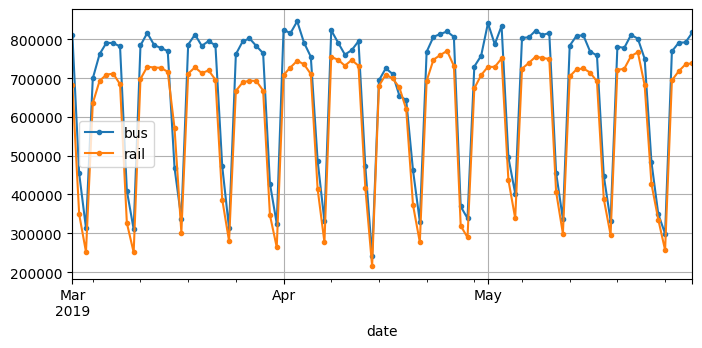

In [5]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8,3.5))
plt.show()

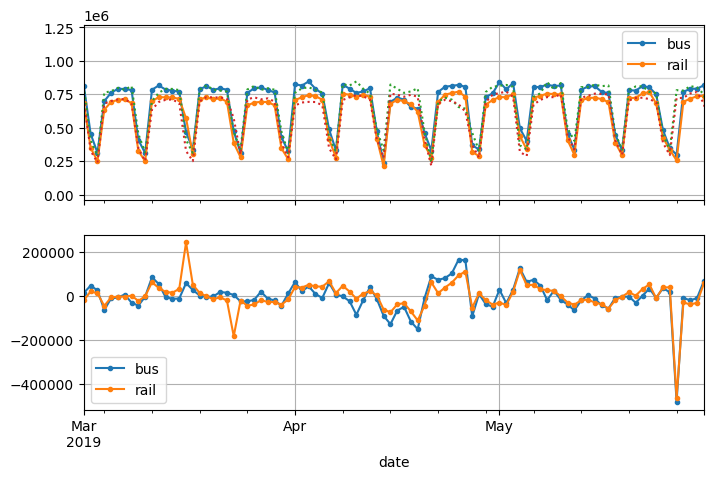

In [6]:
diff_7 = df[["bus","rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2,1,sharex=True, figsize=(8,5))
df.plot(ax=axs[0], grid=True, marker=".")
df.shift(7).plot(ax=axs[0],grid=True,legend=False,linestyle=":")
diff_7.plot(ax = axs[1], grid=True, marker=".")
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

# Model 1: Naive approach

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
targets = df[["bus","rail"]]["2019-03":"2019-05"]

In [10]:
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [11]:
period = slice("2001","2019")

<ipython-input-12-4ad19a42165d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample("M").mean()


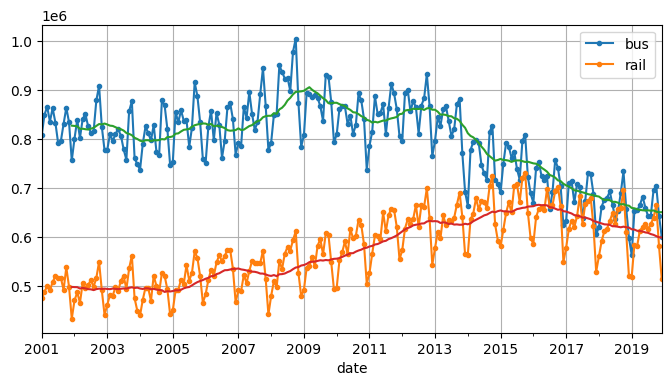

In [12]:
df_monthly = df.resample("M").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker = ".")
rolling_average_12_months.plot(ax = ax, grid=True, legend=False)
plt.show()

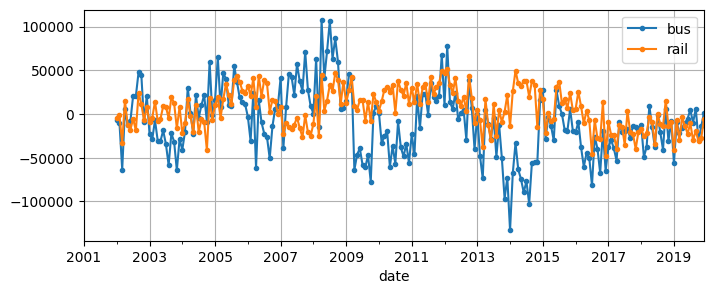

In [13]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))
plt.show()

In [14]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid= df["rail"]["2019-01":"2019-05"] / 1e6
rail_train = df["rail"]["2019-05":] / 1e6

# Data loading with Keras

In [15]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed = 42
)

In [16]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# Model 2: Regression

In [17]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

In [18]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience = 30, restore_best_weights=True
)

In [19]:
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

In [20]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=["mae"])

In [21]:
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=100,
                    callbacks=[early_stopping_cb])

Epoch 1/100
28/28 [==============================] - 2s 36ms/step - loss: 0.0411 - mae: 0.1822 - val_loss: 0.0435 - val_mae: 0.2526
Epoch 2/100
28/28 [==============================] - 1s 16ms/step - loss: 0.0115 - mae: 0.0945 - val_loss: 0.0130 - val_mae: 0.1252
Epoch 3/100
28/28 [==============================] - 1s 15ms/step - loss: 0.0071 - mae: 0.0739 - val_loss: 0.0112 - val_mae: 0.1181
Epoch 4/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0061 - mae: 0.0680 - val_loss: 0.0095 - val_mae: 0.1062
Epoch 5/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0054 - mae: 0.0637 - val_loss: 0.0093 - val_mae: 0.1053
Epoch 6/100
28/28 [==============================] - 1s 14ms/step - loss: 0.0048 - mae: 0.0594 - val_loss: 0.0094 - val_mae: 0.1060
Epoch 7/100
28/28 [==============================] - 1s 14ms/step - loss: 0.0045 - mae: 0.0573 - val_loss: 0.0076 - val_mae: 0.0928
Epoch 8/100
28/28 [==============================] - 0s 12ms/step - loss: 0.

In [22]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae*1e6

3/3 [==============================] - 0s 14ms/step - loss: 0.0029 - mae: 0.0469


46869.95595693588

# Model 3: Simple RNN

In [23]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [24]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs = 100):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience = 30, restore_best_weights=True)
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(),
              optimizer=opt,
              metrics=["mae"])
  history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=epochs,
                    callbacks=[early_stopping_cb])
  valid_loss, valid_mae = model.evaluate(valid_set)
  return valid_mae * 1e6

In [25]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate = 0.05)

Epoch 1/100
28/28 [==============================] - 2s 24ms/step - loss: 0.0389 - mae: 0.2095 - val_loss: 0.0118 - val_mae: 0.1164
Epoch 2/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0037 - mae: 0.0552 - val_loss: 0.0055 - val_mae: 0.0768
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0382 - val_loss: 0.0032 - val_mae: 0.0562
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0017 - mae: 0.0354 - val_loss: 0.0029 - val_mae: 0.0487
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0016 - mae: 0.0353 - val_loss: 0.0027 - val_mae: 0.0453
Epoch 6/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0321 - val_loss: 0.0025 - val_mae: 0.0414
Epoch 7/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0333 - val_loss: 0.0026 - val_mae: 0.0434
Epoch 8/100
28/28 [==============================] - 0s 14ms/step - loss: 0.

38180.48909306526

# Model 4: Deep RNNs

In [26]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True,
                              input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dense(1)
])

In [27]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/100
28/28 [==============================] - 4s 53ms/step - loss: 0.0662 - mae: 0.2703 - val_loss: 0.0494 - val_mae: 0.2802
Epoch 2/100
28/28 [==============================] - 1s 38ms/step - loss: 0.0267 - mae: 0.1834 - val_loss: 0.0511 - val_mae: 0.2847
Epoch 3/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0276 - mae: 0.1893 - val_loss: 0.0630 - val_mae: 0.3151
Epoch 4/100
28/28 [==============================] - 1s 50ms/step - loss: 0.0272 - mae: 0.1867 - val_loss: 0.0625 - val_mae: 0.3138
Epoch 5/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0268 - mae: 0.1880 - val_loss: 0.0714 - val_mae: 0.3368
Epoch 6/100
28/28 [==============================] - 1s 38ms/step - loss: 0.0270 - mae: 0.1857 - val_loss: 0.0586 - val_mae: 0.3038
Epoch 7/100
28/28 [==============================] - 1s 39ms/step - loss: 0.0267 - mae: 0.1853 - val_loss: 0.0435 - val_mae: 0.2655
Epoch 8/100
28/28 [==============================] - 1s 36ms/step - loss: 0.

254865.08011817932

# Model Prediction

In [28]:
import numpy as np

In [29]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
X.shape

(1, 56, 1)

In [30]:
for step_ahead in range(14):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1,1,1)], axis=1)

1/1 [==============================] - 0s 25ms/step


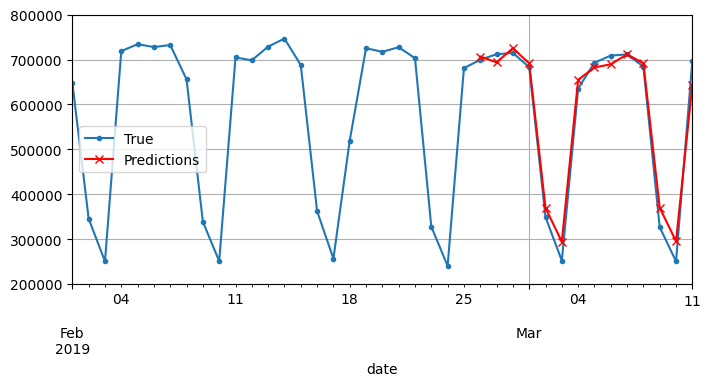

In [31]:
Y_pred = pd.Series(X[0,-14:,0],
                   index=pd.date_range("2019-02-26","2019-03-11"))

fig, ax = plt.subplots(figsize=(8,3.5))
(rail_valid*1e6)["2019-02-01":"2019-03-11"].plot(label=True, marker=".",
                                                 ax=ax)
(Y_pred*1e6).plot(label="Predictions", grid=True, marker="x", color="r",
                  ax = ax)
ax.set_ylim([200_000, 800_000])
plt.legend()
plt.show()

# Model 5: LSTM

In [32]:
tf.random.set_seed(42)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [33]:
fit_and_evaluate(lstm_model, train_ds, valid_ds, learning_rate=0.01, epochs=20)

Epoch 1/20
28/28 [==============================] - 3s 46ms/step - loss: 0.0341 - mae: 0.2075 - val_loss: 0.0500 - val_mae: 0.2823
Epoch 2/20
28/28 [==============================] - 1s 29ms/step - loss: 0.0270 - mae: 0.1820 - val_loss: 0.0504 - val_mae: 0.2833
Epoch 3/20
28/28 [==============================] - 1s 30ms/step - loss: 0.0264 - mae: 0.1833 - val_loss: 0.0587 - val_mae: 0.3040
Epoch 4/20
28/28 [==============================] - 1s 30ms/step - loss: 0.0263 - mae: 0.1827 - val_loss: 0.0585 - val_mae: 0.3036
Epoch 5/20
28/28 [==============================] - 1s 28ms/step - loss: 0.0262 - mae: 0.1831 - val_loss: 0.0617 - val_mae: 0.3118
Epoch 6/20
28/28 [==============================] - 2s 54ms/step - loss: 0.0261 - mae: 0.1815 - val_loss: 0.0601 - val_mae: 0.3077
Epoch 7/20
28/28 [==============================] - 1s 28ms/step - loss: 0.0261 - mae: 0.1834 - val_loss: 0.0608 - val_mae: 0.3094
Epoch 8/20
28/28 [==============================] - 1s 29ms/step - loss: 0.0261 - m

310078.501701355

# Model 6: GRU

In [34]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [35]:
fit_and_evaluate(gru_model, train_ds, valid_ds, learning_rate=0.01, epochs=20)

Epoch 1/20
28/28 [==============================] - 4s 49ms/step - loss: 0.0325 - mae: 0.2044 - val_loss: 0.0524 - val_mae: 0.2883
Epoch 2/20
28/28 [==============================] - 1s 30ms/step - loss: 0.0267 - mae: 0.1804 - val_loss: 0.0507 - val_mae: 0.2841
Epoch 3/20
28/28 [==============================] - 1s 31ms/step - loss: 0.0263 - mae: 0.1829 - val_loss: 0.0559 - val_mae: 0.2970
Epoch 4/20
28/28 [==============================] - 1s 36ms/step - loss: 0.0262 - mae: 0.1844 - val_loss: 0.0619 - val_mae: 0.3122
Epoch 5/20
28/28 [==============================] - 1s 47ms/step - loss: 0.0260 - mae: 0.1810 - val_loss: 0.0543 - val_mae: 0.2930
Epoch 6/20
28/28 [==============================] - 1s 30ms/step - loss: 0.0261 - mae: 0.1852 - val_loss: 0.0618 - val_mae: 0.3120
Epoch 7/20
28/28 [==============================] - 1s 30ms/step - loss: 0.0260 - mae: 0.1812 - val_loss: 0.0610 - val_mae: 0.3099
Epoch 8/20
28/28 [==============================] - 1s 31ms/step - loss: 0.0260 - m

319506.28757476807


## Resources

- [Hands-on ML with Scikit-Learn & TensorFlow](https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb)

Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) | [GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎
